### 10-701 Machine Learning Project
# Image Caption Generation

Team 26  
Olivier Filion  
Michael Agaby  
Nicholas Amano  

All Imports: I'm copy pasting all imports here to stay organized

In [3]:
import sys
print(sys.version)
import json
import os
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
from collections import defaultdict

3.9.2 (tags/v3.9.2:1a79785, Feb 19 2021, 13:44:55) [MSC v.1928 64 bit (AMD64)]


## Utility Functions

In [4]:
import json
import os

def load_captions(path):
    with open(path, "r") as json_file:
        json_dict = json.load(json_file)
    captions = {}
    for annotation in json_dict["annotations"]:
        image_id = annotation["image_id"]
        if image_id not in captions:
            captions[image_id] = []
        captions[image_id].append(annotation["caption"])
    return captions

train_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_train2017.json"))
val_captions = load_captions(os.path.join("dataset", "annotations", "annotations", "captions_val2017.json"))
print(val_captions[139]) 

['A woman stands in the dining area at the table.', 'A room with chairs, a table, and a woman in it.', 'A woman standing in a kitchen by a window', 'A person standing at a table in a room.', 'A living area with a television and a table']


In [5]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer("basic_english")
def preprocess_captions(captions):
    preprocessed_captions = {}
    for image_id in captions:
        preprocessed_captions[image_id] = []
        for caption in captions[image_id]:
            caption = "<start> " + caption.lower().strip() + " <end>"
            caption = tokenizer(caption)
            preprocessed_captions[image_id].append(caption)
    return preprocessed_captions

preprocessed_train_captions = preprocess_captions(train_captions)
preprocessed_val_captions = preprocess_captions(val_captions)
print(preprocessed_val_captions[139])

[['<start>', 'a', 'woman', 'stands', 'in', 'the', 'dining', 'area', 'at', 'the', 'table', '.', '<end>'], ['<start>', 'a', 'room', 'with', 'chairs', ',', 'a', 'table', ',', 'and', 'a', 'woman', 'in', 'it', '.', '<end>'], ['<start>', 'a', 'woman', 'standing', 'in', 'a', 'kitchen', 'by', 'a', 'window', '<end>'], ['<start>', 'a', 'person', 'standing', 'at', 'a', 'table', 'in', 'a', 'room', '.', '<end>'], ['<start>', 'a', 'living', 'area', 'with', 'a', 'television', 'and', 'a', 'table', '<end>']]


In [6]:
from torchtext.vocab import build_vocab_from_iterator

def create_vocabulary(tokenized_captions):
    all_tokens = []
    for image_id in tokenized_captions:
        for caption in tokenized_captions[image_id]:
            all_tokens += caption
    return build_vocab_from_iterator([all_tokens], min_freq=1, specials=["<unk>"])

vocabulary = create_vocabulary(preprocessed_train_captions)
print(len(vocabulary))

28939


In [42]:
from PIL import Image
import torch
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor, Resize, CenterCrop
from functools import lru_cache

IMAGE_WIDTH = 256
IMAGE_HEIGHT = 256

class CaptionDataset(Dataset):

    def __init__(self, image_folder, preprocessed_captions, vocab):
        self.image_folder = image_folder
        self.captions = preprocessed_captions
        self.vocab = vocab
        self.indices = [(image_id, caption_id)
                        for image_id in preprocessed_captions
                        for caption_id in range(len(preprocessed_captions[image_id]))]
        self.tensor_transform = ToTensor()
        self.scale_transform = Resize((IMAGE_WIDTH, IMAGE_HEIGHT))
    
    def __len__(self):
        return len(self.indices)

    @lru_cache(maxsize=128)
    def _get_image(self, image_id, crop_and_scale):
        image_str = str(image_id)
        image_filename = "0" * (12 - len(image_str)) + image_str + ".jpg"
        image_path = os.path.join(self.image_folder, image_filename)
        image = Image.open(image_path)

        if crop_and_scale:
            crop_transform = CenterCrop((min(image.size), min(image.size)))
            image = crop_transform(image)
            image = self.scale_transform(image)
        return self.tensor_transform(image)

    def __getitem__(self, idx, crop_and_scale=True):
        image_id, caption_id = self.indices[idx]
        
        image_tensor = self._get_image(image_id, crop_and_scale)

        caption = self.captions[image_id][caption_id]
        labels = torch.zeros((len(caption), 1))
        for i, token in enumerate(caption):
            token = token if token in self.vocab else "<unk>"
            labels[i][0] = self.vocab[token]

        return image_tensor, labels
  

# Visualizing Some Data

torch.Size([3, 256, 256])
tensor([[3.0000e+00],
        [1.0000e+00],
        [3.5700e+02],
        [3.8150e+03],
        [9.0000e+00],
        [1.0000e+00],
        [8.4000e+01],
        [1.2300e+02],
        [7.0000e+00],
        [4.1000e+01],
        [1.0860e+03],
        [4.0000e+00],
        [2.0000e+00]])
['<start>', 'a', 'bicycle', 'replica', 'with', 'a', 'clock', 'as', 'the', 'front', 'wheel', '.', '<end>']


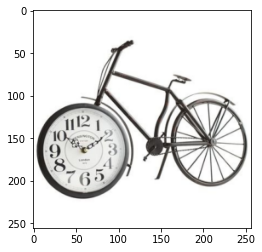

In [44]:
import matplotlib.pyplot as plt

train_ds = CaptionDataset(os.path.join("dataset", "train", "train2017"), preprocessed_train_captions, vocabulary)

im, l = train_ds[0]
print(im.shape)
print(l)

print(preprocessed_train_captions[train_ds.indices[0][0]][train_ds.indices[0][1]])

plt.imshow(im.permute((1, 2, 0)))
plt.show()

['<start>', 'a', 'car', 'that', 'seems', 'to', 'be', 'parked', 'illegally', 'behind', 'a', 'legally', 'parked', 'car', '<end>']
['<start>', 'two', 'cars', 'parked', 'on', 'the', 'sidewalk', 'on', 'the', 'street', '<end>']
['<start>', 'city', 'street', 'with', 'parked', 'cars', 'and', 'a', 'bench', '.', '<end>']
['<start>', 'cars', 'try', 'to', 'maneuver', 'into', 'parking', 'spaces', 'along', 'a', 'densely', 'packed', 'city', 'street', '.', '<end>']
['<start>', 'a', 'couple', 'of', 'cars', 'parked', 'in', 'a', 'busy', 'street', 'sidewalk', '.', '<end>']


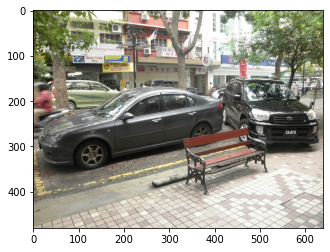

In [45]:
# an example of all 5 captions for one image
im, l = train_ds.__getitem__(10, False)
print(preprocessed_train_captions[train_ds.indices[10][0]][0])
print(preprocessed_train_captions[train_ds.indices[10][0]][1])
print(preprocessed_train_captions[train_ds.indices[10][0]][2])
print(preprocessed_train_captions[train_ds.indices[10][0]][3])
print(preprocessed_train_captions[train_ds.indices[10][0]][4])
plt.imshow(im.permute((1, 2, 0)))
plt.show()

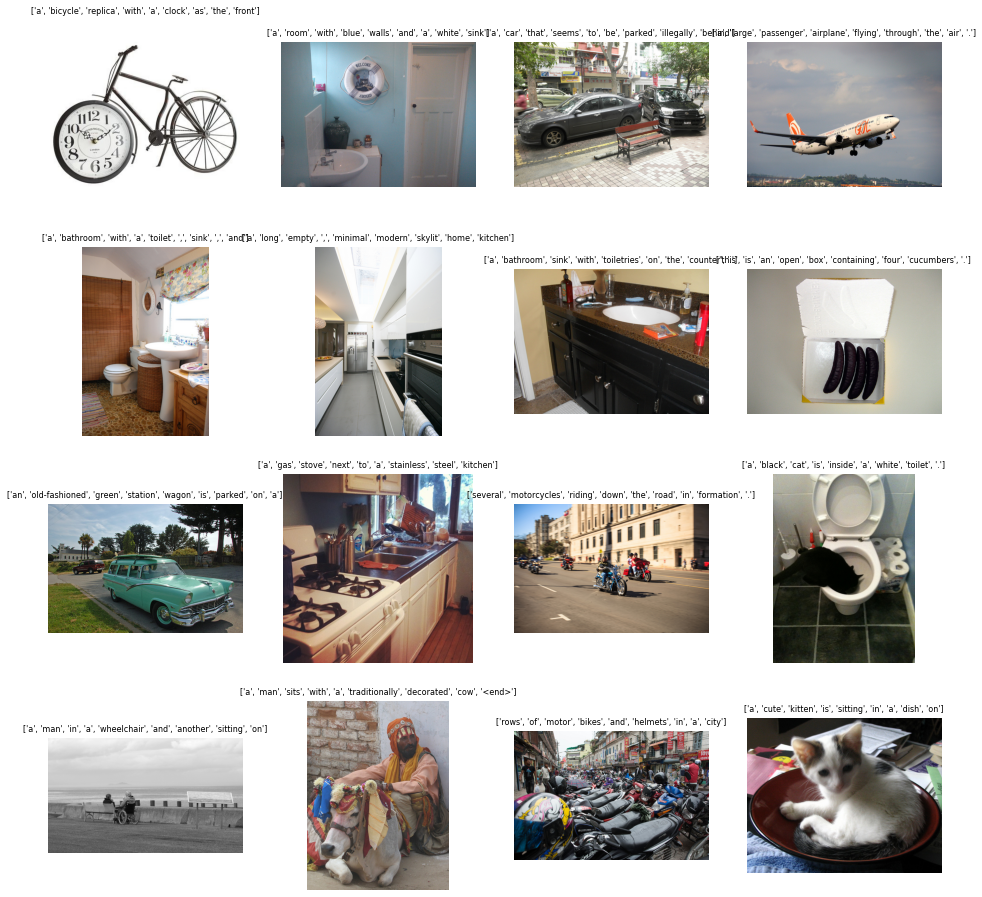

In [25]:
# 16 images as well as the first few wordsw of one of their captions
plt.subplots(figsize=(16,16))

for i in range(16):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(4,4,i+1)
    plt.title(preprocessed_train_captions[train_ds.indices[5*i][0]][0][1:10], fontsize=8)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

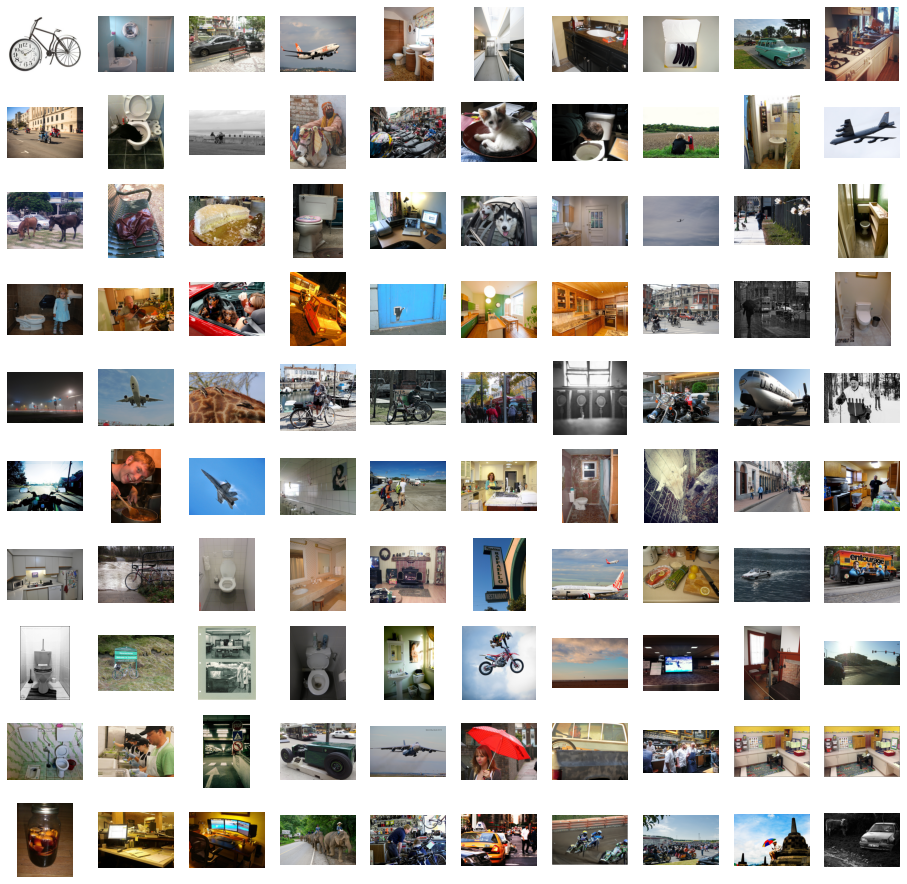

In [26]:
# first 100 images:
plt.subplots(figsize=(16,16))

for i in range(100):
    im, l = train_ds.__getitem__(5*i, False)
    plt.subplot(10,10,i+1)
    plt.imshow(im.permute((1, 2, 0)))
    plt.axis("off")
plt.show()

### Aspect Ratios

Estimating the histogram of aspect ratios by random sampling

0
10000
20000
30000
40000


(array([  5.,  25.,  85., 174., 158., 132., 144., 119., 130.,  97., 104.,
         65.,  48.,  31.,  29.,  21.,  16.,  18.,  12.,   9.,  10.,   8.,
          9.,   5.,   6.,   1.,   4.,   1.,   1.,   2.,   2.,   0.,   2.,
          2.,   0.,   0.,   0.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.24375   , 0.36646146, 0.48917292, 0.61188438, 0.73459585,
        0.85730731, 0.98001877, 1.10273023, 1.22544169, 1.34815315,
        1.47086461, 1.59357608, 1.71628754, 1.838999  , 1.96171046,
        2.08442192, 2.20713338, 2.32984484, 2.45255631, 2.57526777,
        2.69797923, 2.82069069, 2.94340215, 3.06611361, 3.18882508,
        3.31153654, 3.434248  , 3.55695946, 3.67967092, 3.80238238,
        3.92509384, 4.04780531, 4.17051677, 4.29322823, 4.41593969,
        4.53865115, 4.66136261, 4.78407407, 4.90678554, 5.029497  ,
        5.15220846, 5.27491992, 5.39763138, 5.52034284, 5.6430543 ,
        5.76576577]),
 <BarContainer object of 45 artists>)

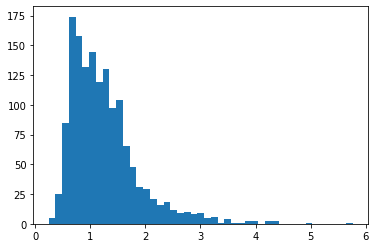

In [28]:
from collections import defaultdict
import random

ratios = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[w/h]+=1
plt.hist(ratios, bins='auto') 

### Area

Estimating histogram of area by random sampling


0
10000
20000
30000
40000


(array([1484.,   18.,   29.,   45.,   83.,  129.,  111.,  123.,  107.,
         103.,   73.,   51.,   47.,   42.,   44.,   44.]),
 array([2.43750000e-01, 2.56002285e+04, 5.12002133e+04, 7.68001980e+04,
        1.02400183e+05, 1.28000168e+05, 1.53600152e+05, 1.79200137e+05,
        2.04800122e+05, 2.30400107e+05, 2.56000091e+05, 2.81600076e+05,
        3.07200061e+05, 3.32800046e+05, 3.58400030e+05, 3.84000015e+05,
        4.09600000e+05]),
 <BarContainer object of 16 artists>)

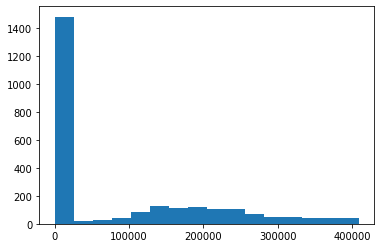

In [29]:
areas = defaultdict(float)

for i in range(50000):
    indx = random.randint(0, len(train_ds))
    if(i%10000==0):
        print(i)
    im, l = train_ds.__getitem__(indx, False)
    h, w = im.shape[1], im.shape[2]
    ratios[h*w]+=1
plt.hist(ratios, bins='auto') 

### Finding the most common words

In [30]:
counts = defaultdict(int)

for captions in preprocessed_train_captions.values():
    for caption in captions:
        for word in caption:
            counts[word]+=1
        
    

In [31]:
sorted_counts = sorted(counts, key=counts.get, reverse=True)
conjuncts = ['has','small','while','some','down','to','<start>','<end>','a','.','on','of','the','in','with','and', 'is', 'an', 'two', 'one', 'at', 'are', 'next'
            ,'there','side','other','is', 'it', 'that','near', 'the', 'his', 'her', 'they', 'up', 'top', ',', ':', ';', '\''
            ,'by','large','front','back']

for word in conjuncts:
    if(word in sorted_counts):
        
        sorted_counts.remove(word)
    
print(sorted_counts[0:50])

['man', 'sitting', 'standing', 'people', 'white', 'woman', 'street', 'table', 'holding', 'person', 'group', 'field', 'tennis', 'black', 'train', 'plate', 'room', 'dog', 'riding', 'red', 'cat', 'young', 'water', 'baseball', 'playing', 'walking', 'bathroom', 'sign', 'blue', 'kitchen', 'food', 'grass', 'bus', 'pizza', 'green', 'parked', 'building', 'bed', 'looking', 'snow', 'beach', 'ball', 'couple', 'three', 'for', 'boy', 'men', 'toilet', 'clock', 'city']
